# **<center>Modelling** 

### Import Packages

In [1]:
import os

from dotenv import load_dotenv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential #type: ignore
from tensorflow.keras.layers import Dense #type: ignore

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from lime.lime_tabular import LimeTabularExplainer

import warnings

from tqdm import tqdm


### Set Preferences

In [2]:
# Change all matplotlib plots to dark mode for my eyes
plt.style.use('dark_background')
# Show all the columns in the .head() method
pd.set_option('display.max_columns', None)

### Set directory

In [3]:
# Load in the dotenv variables
load_dotenv()

# Get the the path variable from dotenv
project_path = os.getenv('Project_Path')[2:78]

# Change notebook directory back one so that it can acess the data
os.chdir(project_path)

### Load the Data

In [4]:
# Load the data that was created in preprocessing
data = pd.read_csv('./data/processed/train.csv')

In [5]:
# Take a look at the data to make sure it has loaded properly
data.head()

loan_amnt      term     grade  annual_inc  pymnt_plan  inq_last_6mths  \
0  -1.156460 -0.654724  0.763889   -0.789014   -0.003357        0.305877   
1  -1.452829  1.527360 -0.314193   -0.696292   -0.003357        4.312132   
2  -1.464683 -0.654724 -0.468204   -0.970563   -0.003357        1.307441   
3  -0.563724 -0.654724  0.147842   -0.399582   -0.003357        0.305877   
4  -1.156460 -0.654724  1.225924   -0.603570   -0.003357        2.309004   

    pub_rec  revol_bal  revol_util  total_acc  initial_list_status  \
0 -0.335522  -0.145932    1.201140  -1.373775             -0.97077   
1 -0.335522  -0.679268   -1.912396  -1.796028             -0.97077   
2 -0.335522  -0.622684    1.821333  -1.289324             -0.97077   
3 -0.335522  -0.504878   -1.426299   0.990842             -0.97077   
4 -0.335522  -0.399424   -1.120393  -1.120423             -0.97077   

   last_pymnt_amnt  last_credit_pull_d  collections_12_mths_ex_med  \
0        -0.415561            0.302329                   -0.107149   
1        -0.426398           -3.540893                   -0.107149   
2        -0.315809            0.302329                   -0.107149   
3        -0.376798           -1.344122                   -0.107149   
4        -0.417770           -0.247992                   -0.107149   

   mths_since_last_major_derog  dti_joint  tot_cur_bal  open_acc_6m   il_util  \
0                     0.576897  -0.023957    -0.843347    -0.103891 -0.139209   
1                     0.576897  -0.023957    -0.843347    -0.103891 -0.139209   
2                     0.576897  -0.023957    -0.843347    -0.103891 -0.139209   
3                     0.576897  -0.023957    -0.843347    -0.103891 -0.139209   
4                     0.576897  -0.023957    -0.843347    -0.103891 -0.139209   

   max_bal_bc  inq_last_12m  emp_type_Accountant  emp_type_Admin  \
0   -0.116273     -0.088306            -0.109205       -0.104843   
1   -0.116273     -0.088306            -0.109205       -0.104843   
2   -0.116273     -0.088306            -0.109205       -0.104843   
3   -0.116273     -0.088306            -0.109205       -0.104843   
4   -0.116273     -0.088306            -0.109205       -0.104843   

   emp_type_Analyst  emp_type_Assistant  emp_type_Clergy  emp_type_Clerk  \
0         -0.157505           -0.147428        -0.039637       -0.077757   
1         -0.157505           -0.147428        -0.039637       -0.077757   
2         -0.157505           -0.147428        -0.039637       -0.077757   
3         -0.157505           -0.147428        -0.039637       -0.077757   
4         -0.157505           -0.147428        -0.039637       -0.077757   

   emp_type_Designer  emp_type_Director  emp_type_Education  \
0          -0.052789          -0.196448           -0.186479   
1          -0.052789          -0.196448           -0.186479   
2          -0.052789          -0.196448           -0.186479   
3          -0.052789          -0.196448           -0.186479   
4          -0.052789          -0.196448           -0.186479   

   emp_type_Executive  emp_type_Healer  emp_type_Manager  emp_type_Operator  \
0           -0.180873        -0.245189         -0.435078          -0.169413   
1           -0.180873        -0.245189         -0.435078          -0.169413   
2           -0.180873        -0.245189         -0.435078          -0.169413   
3           -0.180873        -0.245189         -0.435078          -0.169413   
4           -0.180873        -0.245189         -0.435078          -0.169413   

   emp_type_Technical  emp_type_Vol  home_ownership_OTHER  \
0           -0.395006     -0.172517             -0.016276   
1           -0.395006     -0.172517             -0.016276   
2           -0.395006     -0.172517             -0.016276   
3           -0.395006     -0.172517             -0.016276   
4           -0.395006     -0.172517             -0.016276   

   home_ownership_RENT  verification_status_Source Verified  \
0               1.2214                            -0.768632   
1   

In [6]:
# Make sure that the frac column is respectable
data['frac'].describe()

count    255720.000000
mean          1.014842
std           0.297824
min           0.000000
25%           1.031176
50%           1.102847
75%           1.175711
max           1.763947
Name: frac, dtype: float64

In [5]:
# Create the features by dropping the frac column
X = data.drop('frac', axis = 1)
# Create the target variable from the frac column
y = data['frac']

With the data fully loaded and separated into X and y, I can now use `train_test_split` to separate out the data into training and test sets for the features and target variables.

In [6]:
# Use train_test_split to generate a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

In [9]:
y_test.shape

(63930,)

With all the data ready, I never had a chance to explore `frac`. Below I created a histogram of the distribution of frac to gain an idea of what the model is trying to predict. 

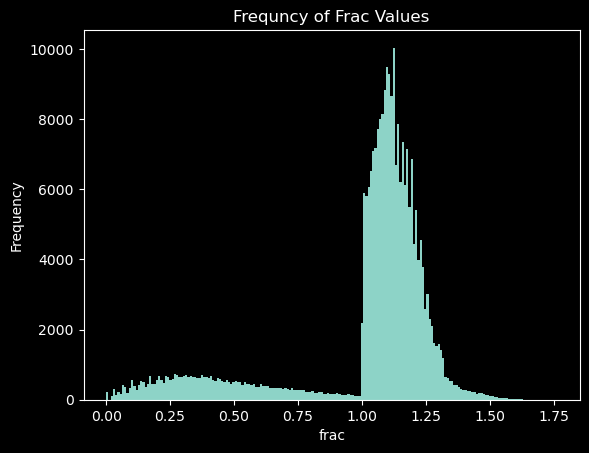

In [10]:
# Create a histogram of the fraction of the loan that was paid off
plt.hist(data = data, x = 'frac', bins = 200);
# Label the x-axis with the 'frac
plt.xlabel("frac");
# Label the y-axis with frequency
plt.ylabel("Frequency")
# Title the plot
plt.title("Frequncy of Frac Values");

Most of the borrowers paid off their loans so the frequency around 1 jumps.  There is also a decline the closer `frac` gets to 1 because it is less likely that a loan that is close to being paid off won't be fully paid off rather than a loan that the borrower has no hope of paying off will not be paid off.

## Neural Networks

#### Define Model Functions
Below I define some functions for the neural network that make it simple to run multiple times. The loss plot shows how well the model was able to train by plotting the loss for each epoch.

In [18]:
# Create a function that takes in the loss from the train_model as an argument
def loss_plot(loss, epochs):
    # Create a plot of the the epics and the losses for each epoch
    plt.plot(range(1, epochs + 1), loss);
    # Label the x-axis of the graph
    plt.xlabel("Epoch #");
    # Label the y-axis of the graph
    plt.ylabel("Cost");
    # Title the graph
    plt.title("Model Cost");
    # Show the plot inside of a function
    plt.show()

Below I create a function that has the neural network. I use the dense model because there none of the data has recurrent patterns or positional concerns that would suggest a recurrent neural network or a convolutional neural network.

In [17]:
def tf_model(X_train, y_train, ep, b_s):
    # Initialize the model
    model = Sequential()

    # Create the first layer of the deep learning model with input set the number of features in X_train
    model.add(Dense(61, activation = 'relu', input_dim = X_train.shape[1]))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(61, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(53, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(38, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(25, activation = 'relu'))
    # Add a middle layer to give the model more complexity
    model.add(Dense(14, activation = 'relu'))
    # Finish with the same amount of nodes as categories that there are to predict
    model.add(Dense(1, activation = 'linear'))
    # Compile the network with the standard optimiizer and loss function
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
    # Train the model with X_train and the encoded categorical y_group
    history = model.fit(X_train.astype('float32'), y_train, epochs = ep, batch_size = b_s)
    # Store the losses in a variable
    losses = history.history['loss']
    loss_plot(losses, int(ep))
    
    return model

With the neural net function I can now train the model with the training data.

Epoch 1/10
39/39 [==============================] - 4s 76ms/step - loss: 0.3471 - mean_absolute_error: 0.4599
Epoch 2/10
39/39 [==============================] - 3s 73ms/step - loss: 0.0852 - mean_absolute_error: 0.2156
Epoch 3/10
39/39 [==============================] - 2s 55ms/step - loss: 0.0741 - mean_absolute_error: 0.1994
Epoch 4/10
39/39 [==============================] - 2s 62ms/step - loss: 0.0688 - mean_absolute_error: 0.1911
Epoch 5/10
39/39 [==============================] - 2s 61ms/step - loss: 0.0635 - mean_absolute_error: 0.1797
Epoch 6/10
39/39 [==============================] - 3s 81ms/step - loss: 0.0583 - mean_absolute_error: 0.1672
Epoch 7/10
39/39 [==============================] - 2s 40ms/step - loss: 0.0539 - mean_absolute_error: 0.1550
Epoch 8/10
39/39 [==============================] - 2s 50ms/step - loss: 0.0509 - mean_absolute_error: 0.1457
Epoch 9/10
39/39 [==============================] - 2s 61ms/step - loss: 0.0489 - mean_absolute_error: 0.1393
Epoch 10/1

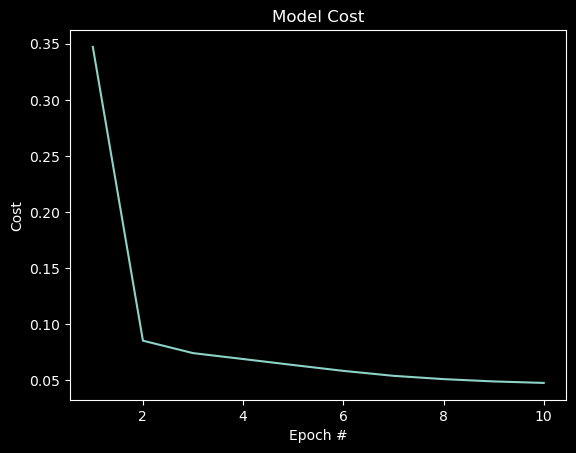

In [19]:
neural_net = tf_model(X_train, y_train, 10, 5000)

This graph shows that the model was able to learn in the training period. In order to ensure that the model didn't over train I can use cross validation so see if the training will be generalizable.

0it [00:00, ?it/s]

Fold 1/5
Epoch 1/5
31/31 [==============================] - 3s 68ms/step - loss: 0.3829 - mean_absolute_error: 0.4968
Epoch 2/5
31/31 [==============================] - 2s 59ms/step - loss: 0.0920 - mean_absolute_error: 0.2292
Epoch 3/5
31/31 [==============================] - 2s 74ms/step - loss: 0.0769 - mean_absolute_error: 0.2037
Epoch 4/5
31/31 [==============================] - 2s 64ms/step - loss: 0.0720 - mean_absolute_error: 0.1958
Epoch 5/5
31/31 [==============================] - 1s 43ms/step - loss: 0.0666 - mean_absolute_error: 0.1862


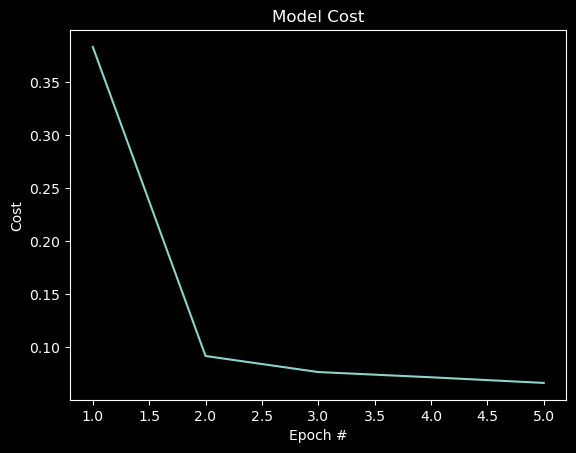

1199/1199 [==============================] - 2s 1ms/step


In [20]:
# Assuming X_train and y_train are Pandas DataFrames
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Set the number of folds
num_folds = 5

# Initialize KFold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Create lists to store training and validation MSE for each fold
train_mse_list = []
val_mse_list = []

# Convert DataFrames to NumPy arrays
X_train_values = X_train.values
y_train_values = y_train.values

# Iterate over folds
for fold, (train_index, val_index) in tqdm(enumerate(kf.split(X_train_values))):
    print(f"Fold {fold + 1}/{num_folds}")
    
    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train_values[train_index], X_train_values[val_index]
    y_train_fold, y_val_fold = y_train_values[train_index], y_train_values[val_index]
    
    # Create the model
    model = tf_model(X_train_fold, y_train_fold, 5, 5000)
    
    # Evaluate the model on training and validation sets
    train_preds = model.predict(X_train_fold)
    val_preds = model.predict(X_val_fold)
    
    train_mse = mean_squared_error(y_train_fold, train_preds)
    val_mse = mean_squared_error(y_val_fold, val_preds)
    val_mae = mean_absolute_error(y_val_fold, val_preds)
    per_error = np.mean(abs(np.array(y_val_fold) - np.array(val_preds)) / np.array(val_preds)) * 100
    
    train_mse_list.append(train_mse)
    val_mse_list.append(val_mse)
    
    print(f"Train MSE: {train_mse:.4f} - Validation MSE: {val_mse:.4f} - Validation MAE: {val_mae:.4f} - Mean Percent Error: {per_error:.4f}%\n")

# Calculate the average validation MSE across all folds
avg_val_mse = np.mean(val_mse_list)
print(f"Average Validation MSE: {avg_val_mse:.4f}")


While this is a very long output, it consistently shows the same result which is an error of slightly under 20 percent. This appears to be good enough to try to test out the model on the test set and see the results

In [15]:
# Run the model and store the predictions in preds
preds = neural_net.predict(X_test)
# Calculate the mean_squared_error
mse = mean_squared_error(y_test, preds)
# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, preds))
# Calculate the mean absolute error
mae = mean_absolute_error(y_test, preds)
# Calculate the percentage of the prediction the error contained
per_error = np.mean((abs(np.array(y_test) - np.array(preds)) / np.array(preds)) * 100)

1998/1998 [==============================] - 2s 1ms/step


Since this is a regression model instead of a classification model, it is a little more complicated to measure the success of the model. I'm using the mean squared error as a way to measure the difference with the predictions compared to the 

MSE: 0.0490 - RMSE: 0.2213 - MAE: 0.1386 - Mean Percent Error: 14.6275%



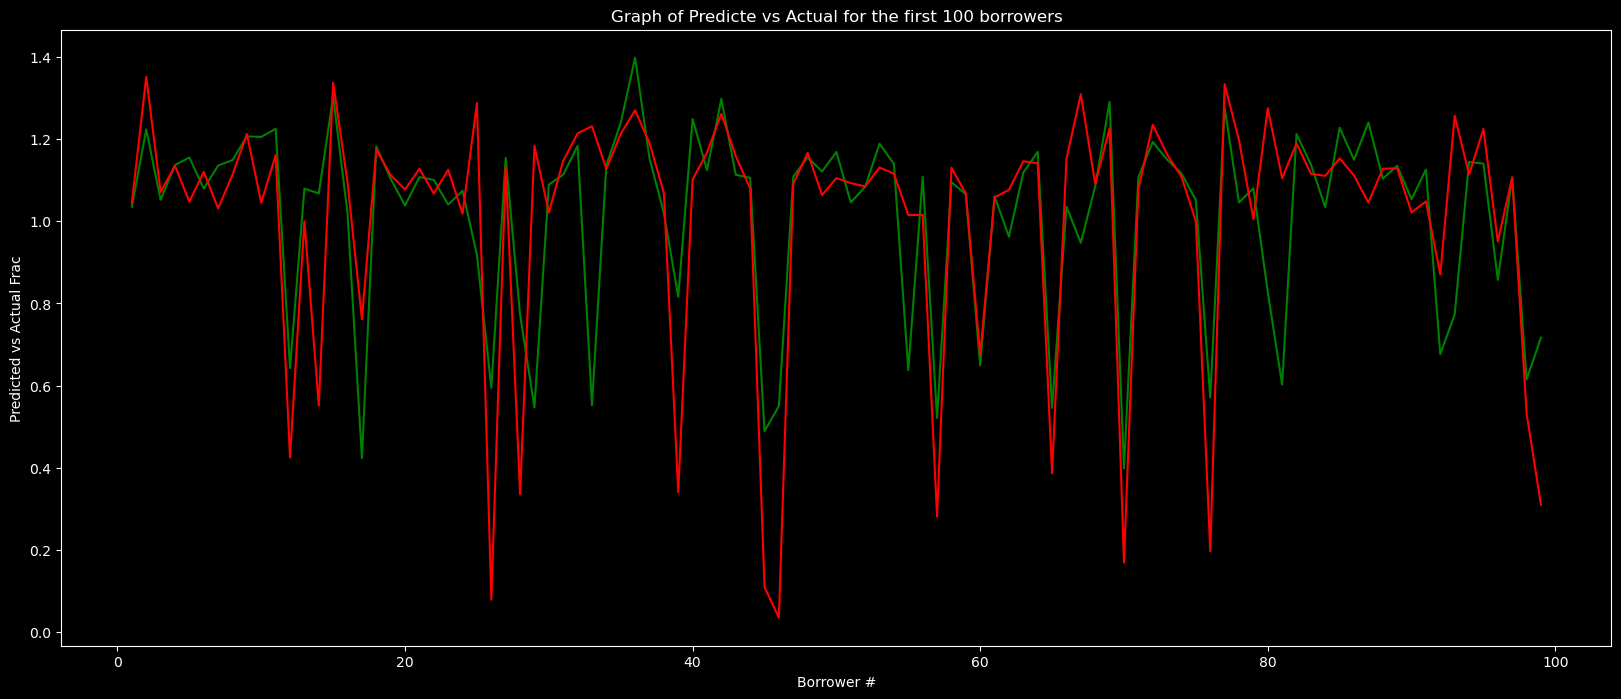

In [17]:
# Print out the results including the Mean Squared Error, Mean Absolute Error, Mean Percent Error
print(f"MSE: {mse:.4f} - RMSE: {rmse:.4f} - MAE: {mae:.4f} - Mean Percent Error: {per_error:.4f}%\n")
# Set the figure size so that the graph is visible
plt.figure(figsize = (20,8))
# plot the predictions in green
plt.plot(range(1, 100), preds[:99], c = 'green');
# Plot the true values in red
plt.plot(range(1, 100), y_test[:99], c = 'red');
# Label the x-axis the as the specific borrower
plt.xlabel('Borrower #');
# Label the y-axis as the amount paid back
plt.ylabel('Predicted vs Actual Frac');
# Title the plot
plt.title("Graph of Predicte vs Actual for the first 100 borrowers");

Now that we have the model and the results, I can use an explainer package to understand how the model arrived at each estimate. Below I load in the explainer

In [17]:
# Create the 
explainer = LimeTabularExplainer(training_data = X_train,
                                 mode='regression', 
                                 feature_names = X_train.columns,
                                 discretize_continuous = False)

Since there are 63930 different loans, it doesn't make sense to print out an explanation for each one. Instead I can create a function that can explain any given loan.

In [18]:
def lime_explanation(loan_number):

    # Instance you want to explain (should match the features of X_train)
    instance_to_explain = X_train.iloc[loan_number]

    # Define a predict function that takes an array of instances and returns predictions
    def predict_fn(instances):
        return model.predict(instances)  # Replace 'your_model' with your trained model

    # Generate explanation
    explanation = explainer.explain_instance(instance_to_explain, predict_fn)

    explanation.show_in_notebook()

With the function above I can pick a random loan and see how the estimate was arrived at

In [19]:
lime_explanation(38674)

157/157 [==============================] - 0s 1ms/step


In [20]:
lime_explanation(5993)

157/157 [==============================] - 0s 2ms/step


Unsurprisingly, the last payment amount is the most important feature in both of the explanations. It makes sense since if the borrower was unable to fully pay their last payment they would have a harder time paying off the rest of the loan. 

Below I look at the biggest mistake the model made.

In [21]:
diff = {i:preds[i] - y_test for i, y_test in enumerate(y_test)}
print(max(diff, key = diff.get), max(diff.values()))

50268 [1.2036037]


In [22]:
lime_explanation(50268)

157/157 [==============================] - 0s 2ms/step


Below I plotted the histogram of the difference of predictions. To see if most of the model is good with some outliers or if there are no good predictions.

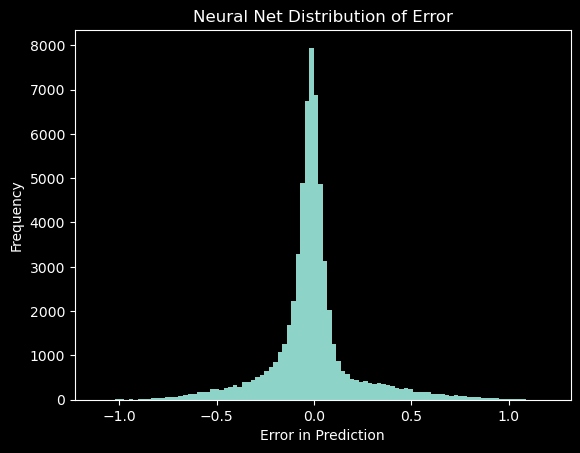

In [35]:
# Create a list of values for all of the differences in prediction
diff_vals = [preds[i] - y_test for i, y_test in enumerate(y_test)]
# Plot the histogram of the differences in prediction
plt.hist(np.array(diff_vals), bins = 100);
# Label the prediction
plt.xlabel("Error in Prediction");
# Label the y-axis
plt.ylabel("Frequency");
# Title the plot
plt.title("Neural Net Distribution of Error");

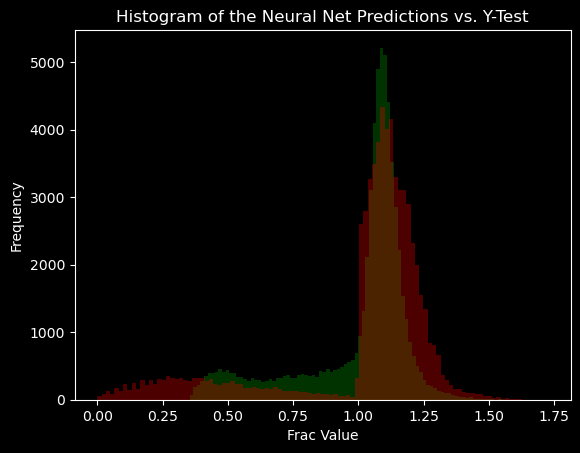

In [33]:
# Plot the predictions from the neural network
plt.hist(preds, bins = 100, color = 'green', alpha = .4);
# Plot the actual results
plt.hist(y_test, bins = 100, color = 'red', alpha = .3);
# Label the x-axis as the target variable value
plt.xlabel("Frac Value");
# Label the y-axis as the frequency
plt.ylabel("Frequency");
# Title the graph
plt.title("Histogram of the Neural Net Predictions vs. Y-Test");

## **Random Forests**

In [44]:
# Initialize a random forest model
rf = RandomForestRegressor(n_jobs = 4)
# Create a set of values to search
param_grid = {'n_estimators': [5, 50, 100, 150, 200, 300, 600]}  
# Create the grid search object with 5 cross validational folds
grid_search = GridSearchCV(rf, param_grid, cv = 2, verbose = 1)  
# Fit the data to the grid search
grid_search.fit(X_train, y_train)
# Save the best parameters  
best_params = grid_search.best_params_
# Print the best parameters
best_params

Fitting 2 folds for each of 7 candidates, totalling 14 fits


{'n_estimators': 600}

In [ ]:
mean_absolute_error(y_test, rf_pred)``

In [8]:
# Create a random forest classifier with the best parameters trees
rf = RandomForestRegressor(n_estimators= 600, n_jobs = 4)

# Fit the model to the data
rf.fit(X_train, y_train)

# Predict the test set
rf_pred = rf.predict(X_test)

In [16]:
np.mean(abs(np.array(y_test)-np.array(rf_pred))/np.array(rf_pred))*100

14.217476774220792

In [14]:
# Calculate the mean squared error
rf_mse = mean_squared_error(y_test, rf_pred)
# Calculate the root mean squared error
rf_rmse = np.sqrt(rf_mse)
# Calculate the mean absolute error
rf_mae = mean_absolute_error(y_test, rf_pred)
# Calculate the percentage of the prediction the error contained
rf_per_error = np.mean(rf_mae / rf_pred) * 100

In [15]:
print(f"MSE: {rf_mse:.4f} - RMSE - {rf_rmse:.4f} - MAE: {rf_mae:.4f} - Mean Percent Error: {rf_per_error:.4f}%\n")

MSE: 0.0309 - RMSE - 0.1758 - MAE: 0.0872 - Mean Percent Error: 11.1239%



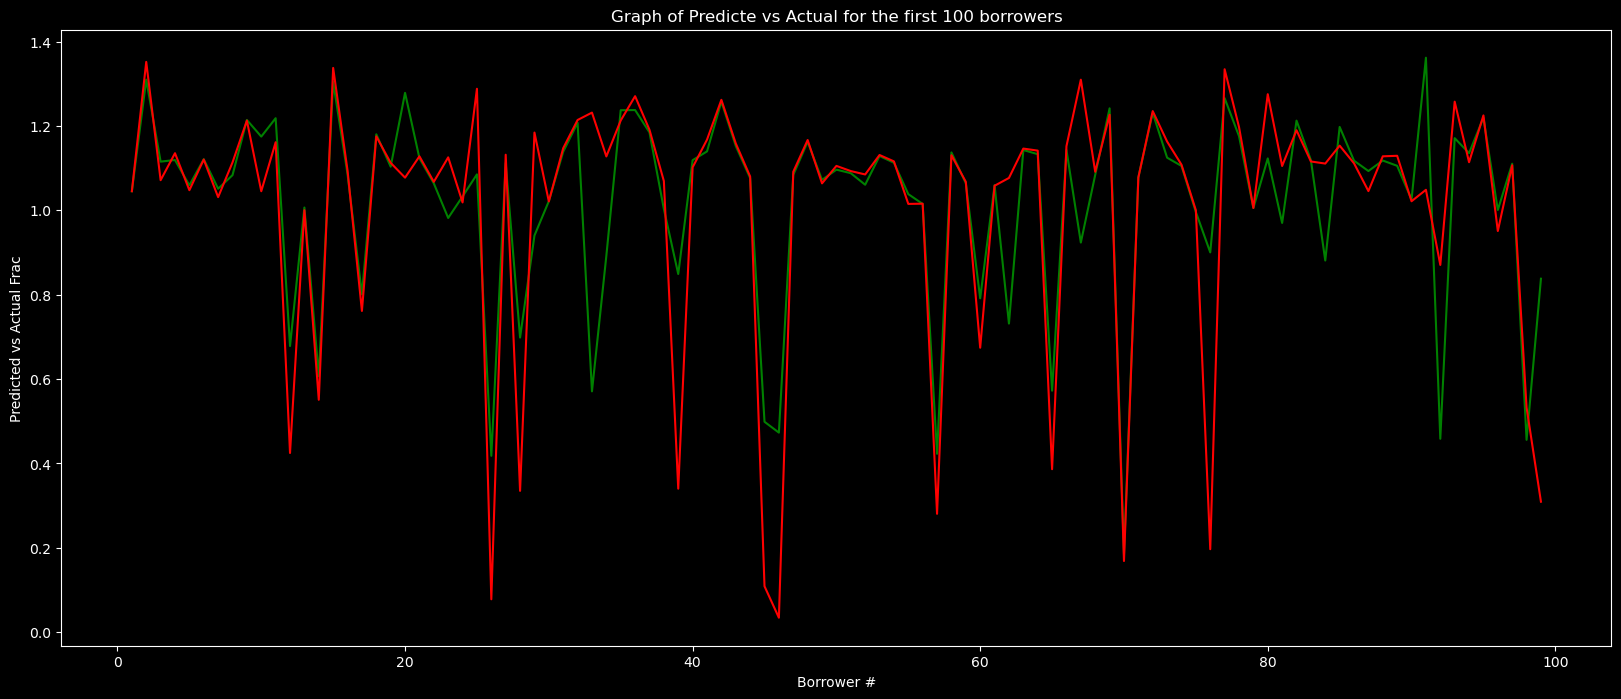

In [30]:
# Change the figure size to better visualize the graph
plt.figure(figsize = (20,8))
# Plot the predictions in green
plt.plot(range(1, 100), rf_pred[:99], c = 'green');
# Plot the results in red
plt.plot(range(1, 100), y_test[:99], c = 'red');
# Label the x-axis for each loan
plt.xlabel('Borrower #');
# Label the y-axis for target variable value
plt.ylabel('Predicted vs Actual Frac');
# Title the plot
plt.title("Graph of Predicte vs Actual for the first 100 borrowers");

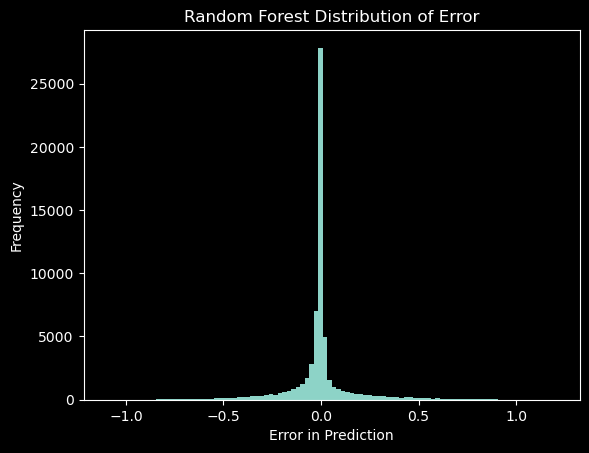

In [32]:
# Create a list of values for all of the differences in prediction
rf_diff_vals = [rf_pred[i] - y_test for i, y_test in enumerate(y_test)]
# Plot the histogram of the differences in prediction
plt.hist(np.array(rf_diff_vals), bins = 100);
# Label the prediction
plt.xlabel("Error in Prediction");
# Label the y-axis
plt.ylabel("Frequency");
# Title the plot
plt.title("Random Forest Distribution of Error");

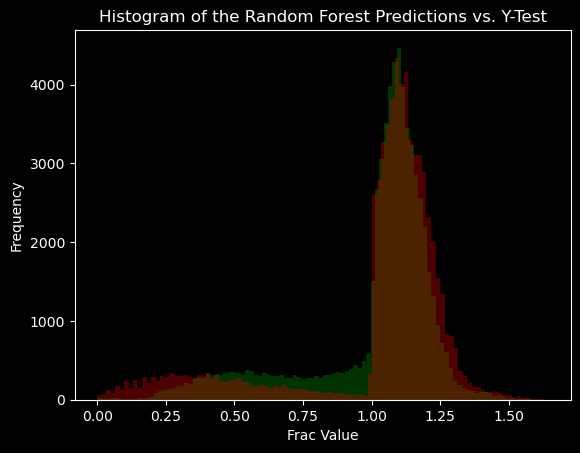

In [37]:
# Plot the predictions from the random forest
plt.hist(rf_pred, bins = 100, color = 'green', alpha = .4);
# Plot the actual results
plt.hist(y_test, bins = 100, color = 'red', alpha = .3);
# Label the x-axis as the target variable value
plt.xlabel("Frac Value");
# Label the y-axis as the frequency
plt.ylabel("Frequency");
# Title the graph
plt.title("Histogram of the Random Forest Predictions vs. Y-Test");

In [45]:
def lime_explanation_rf(loan_number):

    # Instance you want to explain (should match the features of X_train)
    instance_to_explain = X_train.iloc[loan_number,:]

    # Define a predict function that takes an array of instances and returns predictions
    def predict_fn(instances):
        return rf.predict(instances) 

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)  # Ignore the specific UserWarning
        # Generate explanation
        explanation = explainer.explain_instance(instance_to_explain, predict_fn)

    explanation.show_in_notebook()

In [46]:
# Generate the lime explanation without the warning message
lime_explanation_rf(8976)

In [52]:
# Load the active loans to create the market for them
active_loans = pd.read_csv('./data/processed/predict.csv')[:]

In [54]:
# Drop the $_expected since that wasn't in the training datasets for the model
active_loans_X = active_loans.drop('$_expected', axis = 1)
# Look at the model
active_loans_X.head()

loan_amnt     term     grade  annual_inc  pymnt_plan  inq_last_6mths  \
0  -1.393555  1.52736  0.301854    0.076390   -0.003357       -0.695687   
1  -0.919366  1.52736 -0.468204   -0.433518   -0.003357        0.305877   
2  -0.563724  1.52736 -0.468204   -0.709891   -0.003357        0.305877   
3  -0.267356  1.52736  0.301854   -0.742653   -0.003357        2.309004   
4   0.325381  1.52736 -0.930239   -0.541755   -0.003357        0.305877   

    pub_rec  revol_bal  revol_util  total_acc  initial_list_status  \
0 -0.335522   0.484341   -0.047627   1.075293             -0.97077   
1 -0.335522   0.035904    1.280760  -1.204874             -0.97077   
2 -0.335522  -0.034012    0.358851   0.484138             -0.97077   
3 -0.335522  -0.302218   -0.211056  -0.107016             -0.97077   
4 -0.335522  -0.276312    0.161898  -1.627127             -0.97077   

   last_pymnt_amnt  last_credit_pull_d  collections_12_mths_ex_med  \
0        -0.437216            0.302329                   -0.107149   
1        -0.415883            0.302329                   -0.107149   
2        -0.400681            0.302329                   -0.107149   
3        -0.392449            0.302329                   -0.107149   
4        -0.404691            0.302329                   -0.107149   

   mths_since_last_major_derog  dti_joint  tot_cur_bal  open_acc_6m   il_util  \
0                     0.576897  -0.023957    -0.843347    -0.103891 -0.139209   
1                     0.576897  -0.023957    -0.843347    -0.103891 -0.139209   
2                     0.576897  -0.023957    -0.843347    -0.103891 -0.139209   
3                     0.576897  -0.023957    -0.843347    -0.103891 -0.139209   
4                     0.576897  -0.023957    -0.843347    -0.103891 -0.139209   

   max_bal_bc  inq_last_12m  emp_type_Accountant  emp_type_Admin  \
0   -0.116273     -0.088306            -0.109205       -0.104843   
1   -0.116273     -0.088306            -0.109205       -0.104843   
2   -0.116273     -0.088306            -0.109205       -0.104843   
3   -0.116273     -0.088306            -0.109205       -0.104843   
4   -0.116273     -0.088306            -0.109205       -0.104843   

   emp_type_Analyst  emp_type_Assistant  emp_type_Clergy  emp_type_Clerk  \
0         -0.157505           -0.147428        -0.039637       -0.077757   
1         -0.157505           -0.147428        -0.039637       -0.077757   
2         -0.157505           -0.147428        -0.039637       -0.077757   
3         -0.157505           -0.147428        -0.039637       -0.077757   
4         -0.157505           -0.147428        -0.039637       -0.077757   

   emp_type_Designer  emp_type_Director  emp_type_Education  \
0          -0.052789          -0.196448           -0.186479   
1          -0.052789          -0.196448           -0.186479   
2          -0.052789          -0.196448           -0.186479   
3          -0.052789          -0.196448           -0.186479   
4          -0.052789          -0.196448           -0.186479   

   emp_type_Executive  emp_type_Healer  emp_type_Manager  emp_type_Operator  \
0           -0.180873        -0.245189         -0.435078          -0.169413   
1           -0.180873         4.078482         -0.435078          -0.169413   
2           -0.180873        -0.245189         -0.435078          -0.169413   
3           -0.180873        -0.245189         -0.435078          -0.169413   
4           -0.180873        -0.245189         -0.435078          -0.169413   

   emp_type_Technical  emp_type_Vol  home_ownership_OTHER  \
0            2.531605     -0.172517             -0.016276   
1           -0.395006     -0.172517             -0.016276   
2           -0.395006     -0.172517             -0.016276   
3            2.531605     -0.172517             -0.016276   
4           -0.395006     -0.172517             -0.016276   

   home_ownership_RENT  verification_status_Source Verified  \
0               1.2214                             1.301013   
1         

Since the Random Forest is clearly the better option, I will generate the predictions with the random forest. There is no way to test the accuracy of the predictions but since they are the end product of the project and would be calculated in a business environment, I will calculate them here.

In [55]:
# Generate the loan market
Loan_Market = rf.predict(active_loans_X)